Contact: marine.mamin@gmail.com



#Librairies

In [69]:
from google.colab import drive
import os as os
from requests import get
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import scipy as sc
from operator import itemgetter

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split,GroupShuffleSplit, KFold, GroupKFold,cross_val_score,GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.exceptions import ConvergenceWarning

from sklearn.pipeline import Pipeline
from sklearn.metrics import balanced_accuracy_score, recall_score , average_precision_score , roc_auc_score,accuracy_score,precision_score,roc_curve, auc,precision_recall_curve, make_scorer, f1_score, confusion_matrix

#Load file

In [70]:
Data_whole = pd.read_excel("./data/PTR_Outdoors.xlsx")

In [71]:
print(Data_whole.shape)

(19128, 36)


In [72]:
# Convert 'Day' from int to object type
Data_whole['Day'] = Data_whole['Day'].astype(str)

#Ensure measurement length

In [73]:
# Define the number of rows to keep
num_rows = 60

# Group by Sample_ID and keep the first num_rows rows for each group
Data_cut = Data_whole.groupby('Sample_ID').apply(lambda x: x.iloc[:num_rows])

# Reset the index
Data_cut = Data_cut.reset_index(drop=True)

# Print the shape of the resulting DataFrame
print(Data_cut.shape)


(18960, 36)


In [74]:
Data_cut_check = Data_cut.drop_duplicates(subset='Sample_ID')
Data_cut_check.shape

(316, 36)

#Subsets

In [75]:
D12cm = Data_cut[Data_cut['Distance'] == '12cm'].copy()
D45cm = Data_cut[Data_cut['Distance'] == '45cm'].copy()

# Check class distribution


In [76]:
D12cm_check = Data_cut[Data_cut['Distance'] == '12cm'].drop_duplicates(subset='Sample_ID')
D45cm_check = Data_cut[Data_cut['Distance'] == '45cm'].drop_duplicates(subset='Sample_ID')

# Function to get counts for Treatment and Treatment by Day
def get_counts(df):
    treatment_counts = df['Treatment'].value_counts()
    treatment_by_day = df.groupby('Day')['Treatment'].value_counts()
    return treatment_counts, treatment_by_day

# Get counts for Close
D12cm_treatment_counts, D12cm_treatment_by_day = get_counts(D12cm_check)
print("Counts for 1-2cm:")
print("Total occurrences of each level of 'Treatment':")
print(D12cm_treatment_counts)
print("\nOccurrences of 'Treatment' by 'Day':")
print(D12cm_treatment_by_day)

# Get counts for Far
D45cm_treatment_counts, D45cm_treatment_by_day = get_counts(D45cm_check)
print("\nCounts for 4-5cm:")
print("Total occurrences of each level of 'Treatment':")
print(D45cm_treatment_counts)
print("\nOccurrences of 'Treatment' by 'Day':")
print(D45cm_treatment_by_day)


Counts for 1-2cm:
Total occurrences of each level of 'Treatment':
Treatment
Damaged    81
Control    77
Name: count, dtype: int64

Occurrences of 'Treatment' by 'Day':
Day  Treatment
1    Damaged      27
     Control      25
2    Damaged      28
     Control      22
3    Control      30
     Damaged      26
Name: count, dtype: int64

Counts for 4-5cm:
Total occurrences of each level of 'Treatment':
Treatment
Damaged    81
Control    77
Name: count, dtype: int64

Occurrences of 'Treatment' by 'Day':
Day  Treatment
1    Damaged      27
     Control      25
2    Damaged      28
     Control      22
3    Control      30
     Damaged      26
Name: count, dtype: int64


# PCAs

In [77]:
DataVOC = Data_cut.copy()

In [78]:
keep_columns = [ 'Plant', 'Distance', 'Day', 'Treatment']
average_columns = DataVOC.loc[:, 'C3H5O':'C15H27O'].columns.tolist()
Data60 = DataVOC.groupby(['Sample_ID'] + keep_columns)[average_columns].mean().reset_index()
Data60.set_index('Sample_ID', inplace=True)
Data60.shape

(316, 35)

Prepare env. data

In [79]:
AddData = pd.read_excel("./data/Env_Outdoors.xlsx")
AddData.set_index('Sample_ID', inplace=True)

PCA

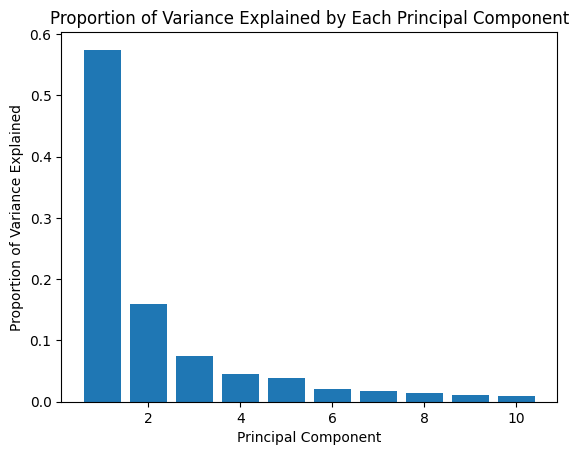

In [80]:
import plotly.express as px
from sklearn.decomposition import PCA

# Standardize the data
scaler = StandardScaler()
data_pca =  Data60.loc[:, 'C3H5O':'C15H27O'].copy()
data_pca_scaled = pd.DataFrame(scaler.fit_transform(data_pca),
                                   columns=data_pca.columns,
                                   index=data_pca.index)

# Perform PCA
pca = PCA(n_components=10)  # You can choose the number of components
pca_result = pca.fit_transform(data_pca_scaled)

# Get explained variance ratios
explained_variance_ratios = pca.explained_variance_ratio_

# Plot bar plot
plt.bar(range(1, len(explained_variance_ratios) + 1), explained_variance_ratios, align='center')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.title('Proportion of Variance Explained by Each Principal Component')
plt.show()

In [81]:
pca_df = pd.DataFrame(data=pca_result, index=data_pca_scaled.index,columns=[f'PC{i+1}' for i in range(pca_result.shape[1])])
pca_df = pd.concat([pca_df, Data60[['Treatment', 'Day','Distance']]], axis=1)
pca_df = pca_df.merge(AddData[['Temperature', 'Humidity']], left_index=True, right_index=True)
pca_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,Treatment,Day,Distance,Temperature,Humidity
Sample_ID,,,,,,,,,,,,,,,
C_10_12cm_1,1.288691,-1.162543,-0.041686,-2.077971,0.872251,0.885162,0.094380,0.125821,-0.304746,-0.299463,Control,1,12cm,22.5,52
C_10_12cm_2,-4.262542,-0.781877,-0.454441,-0.177346,-0.764593,-0.686555,-0.087351,0.422062,0.133014,-0.020202,Control,2,12cm,19.9,49
C_10_12cm_3,-2.705429,-0.384270,3.981091,-1.586404,-0.993263,-0.249762,-0.426103,0.405077,-0.254328,-0.128079,Control,3,12cm,22.7,38
C_10_45cm_1,0.559505,-1.614828,-0.553953,-1.194910,0.161294,1.124043,-0.500017,-0.255148,-0.493761,-0.470427,Control,1,45cm,22.5,52
C_10_45cm_2,-4.255045,-0.785715,-1.405385,0.464009,-0.354060,-0.065860,-0.413571,0.021505,-0.278786,-0.027765,Control,2,45cm,19.9,49


Plot

<ipython-input-82-f63e92e31876>:18: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


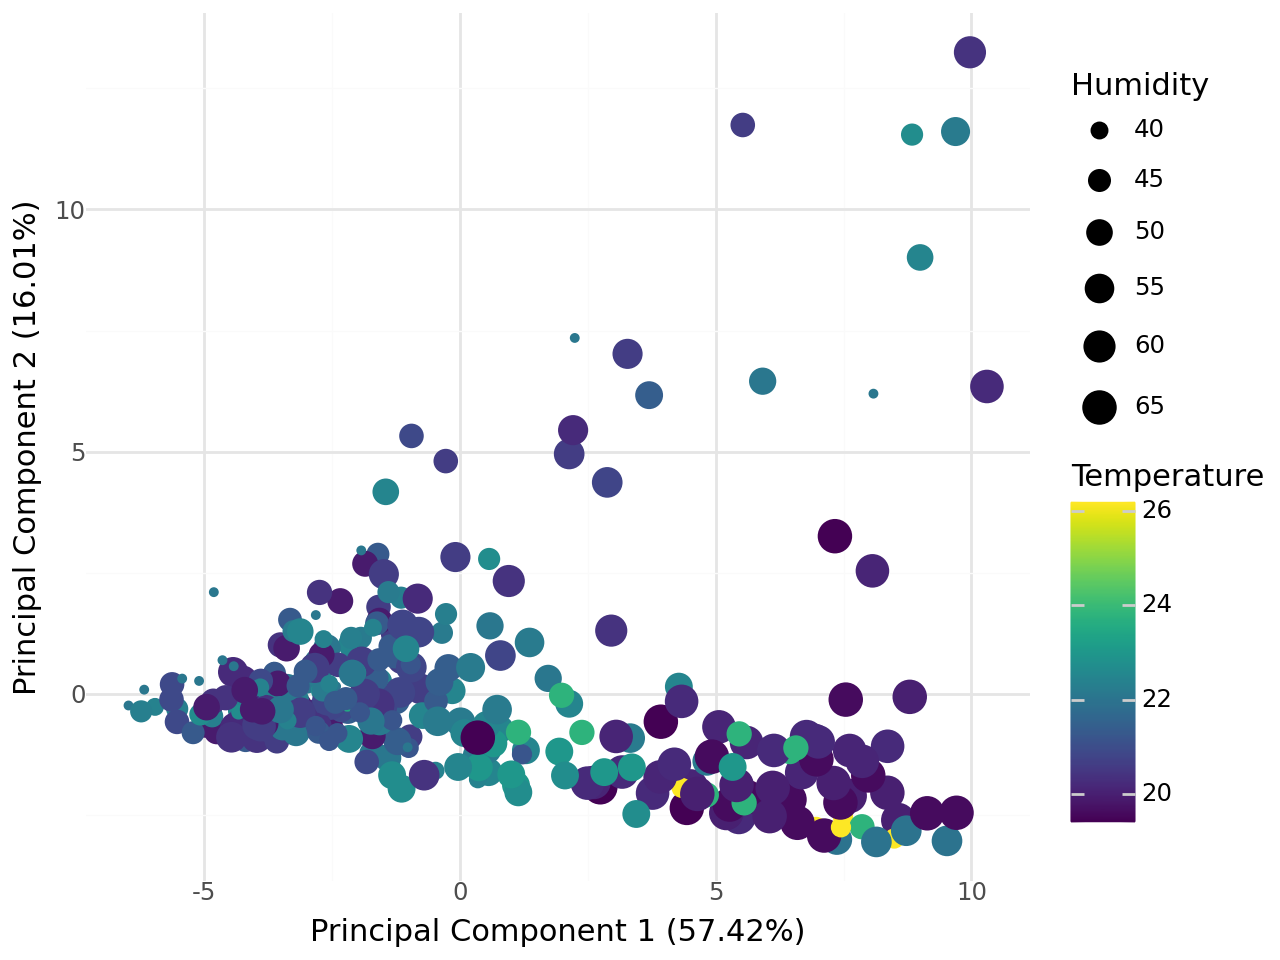

<ipython-input-82-f63e92e31876>:35: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().
/usr/local/lib/python3.10/dist-packages/plotnine/guides/guides.py:207: PlotnineWarning: Cannot generate legend for the 'size' aesthetic. Make sure you have mapped a variable to it


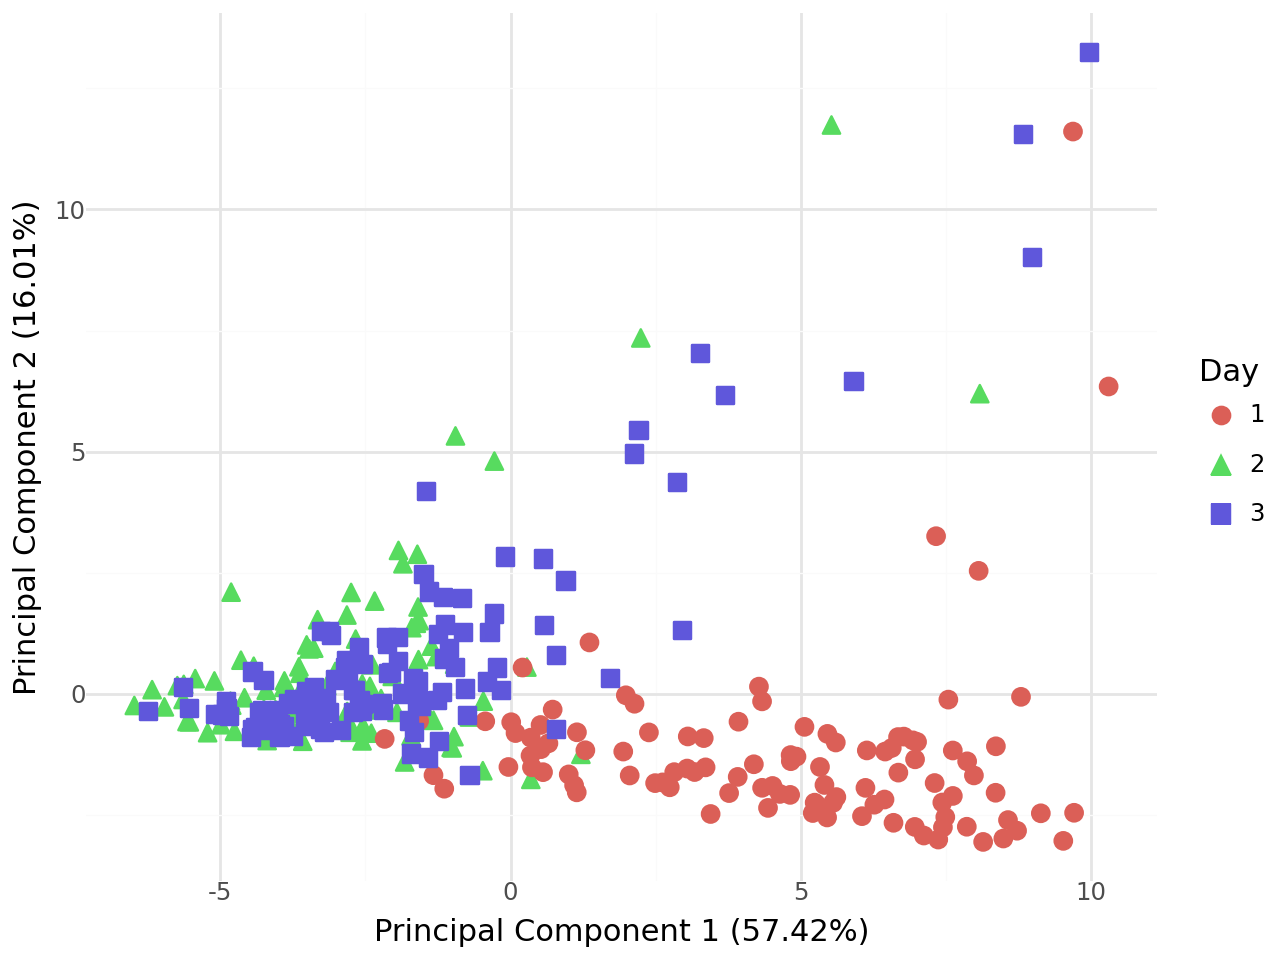

<ipython-input-82-f63e92e31876>:52: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().
/usr/local/lib/python3.10/dist-packages/plotnine/guides/guides.py:207: PlotnineWarning: Cannot generate legend for the 'size' aesthetic. Make sure you have mapped a variable to it


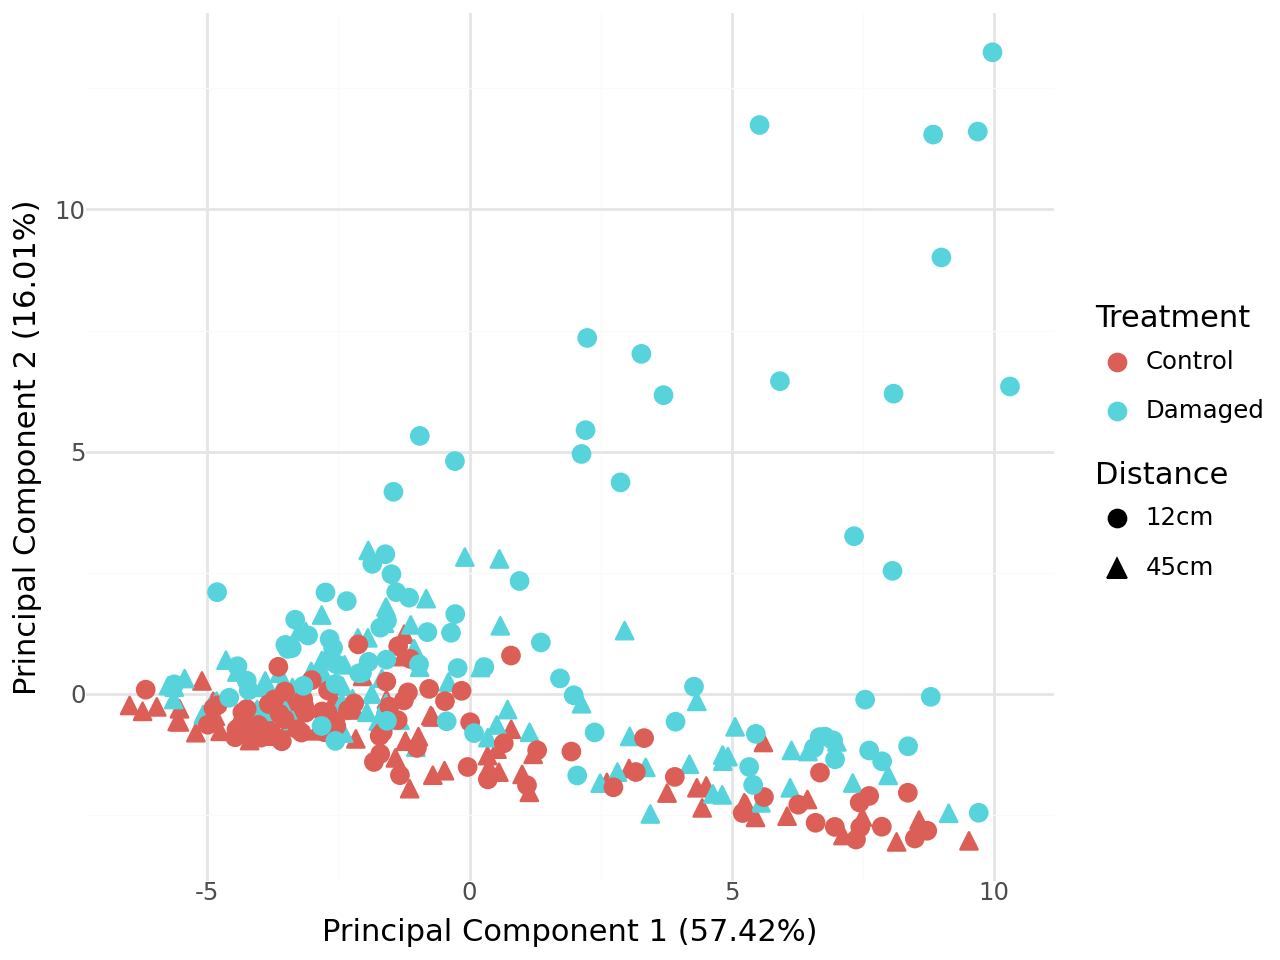

In [82]:
from plotnine import ggplot, aes, geom_point, scale_size_continuous, theme_minimal, labs


# Create the scatter plot Temperature and Humidity Gradient
fig = (
    ggplot(pca_df, aes(x='PC1', y='PC2', color='Temperature', size='Humidity')) +
    geom_point() +
    scale_size_continuous() +
    theme_minimal() +
    labs(#title='PCA Visualization with Temperature and Humidity Gradient',
         x='Principal Component 1',
         y='Principal Component 2',
         color='Temperature')+
    labs(x='Principal Component 1 ({:.2f}%)'.format(explained_variance_ratios[0]*100),
         y='Principal Component 2 ({:.2f}%)'.format(explained_variance_ratios[1]*100))
)

print(fig)

# Create the scatter plot by Day
fig = (
    ggplot(pca_df, aes(x='PC1', y='PC2', color='Day',shape='Day')) +
    geom_point(size=3) +
    scale_size_continuous() +
    theme_minimal() +
    labs(#title='PCA Visualization by Day',
         x='Principal Component 1',
         y='Principal Component 2',
         color='Day',
         shape='Day')+
    labs(x='Principal Component 1 ({:.2f}%)'.format(explained_variance_ratios[0]*100),
         y='Principal Component 2 ({:.2f}%)'.format(explained_variance_ratios[1]*100))
)

print(fig)


# Create the scatter plot Treatment and Distance
fig = (
    ggplot(pca_df, aes(x='PC1', y='PC2', color='Treatment',shape='Distance')) +
    geom_point(size=3) +
    scale_size_continuous() +
    theme_minimal() +
    labs(#title='PCA Visualization by Treatment and Distance',
         x='Principal Component 1',
         y='Principal Component 2',
         color='Treatment')+
    labs(x='Principal Component 1 ({:.2f}%)'.format(explained_variance_ratios[0]*100),
         y='Principal Component 2 ({:.2f}%)'.format(explained_variance_ratios[1]*100))
)

print(fig)

# **A) 1-2 cm Distance**

##1) Test classifiers on all intervals from each 60-second measurements

### Cut into intervals

In [83]:
Data = D12cm.copy()

# Define the time intervals
time_intervals = [1, 5, 15, 30, 60]

# Initialize an empty dictionary to store the resulting DataFrames
result_dfs = {}

# Loop over each time interval
for interval in time_intervals:
    # Group by Sample_ID and cut the data into parts of the current time interval
    df = Data.groupby('Sample_ID').apply(lambda x: x.assign(measurement_ID=x.name + '_' + (x.index//interval).astype(str)).iloc[:x.shape[0]//interval*interval])

    # Reset the index
    df = df.reset_index(drop=True)

    # Store the resulting DataFrame in the dictionary with a unique name
    result_dfs[f'df_{interval}'] = df

### Take the average value of the invervals

In [84]:
# Define the columns to keep
keep_columns = ['Sample_ID', 'Plant', 'Distance', 'Day', 'Treatment']

# Initialize an empty dictionary to store the resulting DataFrames
result_avg_dfs = {}

# Loop over each DataFrame in the dictionary
for name, df in result_dfs.items():
    # Get the columns
    average_columns = df.loc[:, 'C3H5O':'C15H27O'].columns.tolist()

    # Calculate the average for the specified columns for each measurement_ID
    df_avg = df.groupby(['measurement_ID'] + keep_columns)[average_columns].mean().reset_index()

    # Store the resulting DataFrame in the dictionary with a unique name
    result_avg_dfs[f'{name}_avg'] = df_avg

### Train-Test separation

The group_split function performs a grouped split of the dataset into training and testing sets, ensuring that data from the same plant are not split between the training and testing sets. This helps to avoid data leakage and ensures a more robust evaluation of the model

In [85]:
# Initialize dictionaries to store results
plants_train_dict = {}
plants_test_dict = {}

X_train_dict = {}
X_test_dict = {}
Y_train_dict = {}
Y_test_dict = {}

# Function to perform grouped split
def group_split(X, y, group, train_size=0.7):
    splitter = GroupShuffleSplit(train_size=train_size, random_state=10)
    train, test = next(splitter.split(X, y, groups=group))
    return (X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test])

# Iterate over each key in the dictionary
for key, df in result_avg_dfs.items():
    # Define X and y
    X_plants = df.drop(['Treatment', 'Day','Plant','measurement_ID','Distance'], axis=1)
    y = df['Treatment']

    # Encode the labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    y_encoded = pd.Series(y_encoded, index=y.index, name='Encoded_Column')

    # Perform the grouped split
    X_train, X_test, y_train, y_test = group_split(X_plants, y_encoded, X_plants['Sample_ID'])

    # Separate X_train into features and groups
    plants_train = X_train['Sample_ID']
    plants_test = X_test['Sample_ID']
    X_train = X_train.drop('Sample_ID', axis=1)
    X_test = X_test.drop('Sample_ID', axis=1)

    # Store the results in the dictionaries
    plants_train_dict[key] = plants_train
    plants_test_dict[key] = plants_test
    X_train_dict[key] = X_train
    Y_train_dict[key] = y_train
    X_test_dict[key] = X_test
    Y_test_dict[key] = y_test

# Print the number of each class in the train set
for key, y_train in Y_train_dict.items():
    class_counts = y_train.value_counts()
    print(f"Class distribution in train set for {key}:")
    print(class_counts)

# Print the number of each class in the test set
for key, y_test in Y_test_dict.items():
    class_counts = y_test.value_counts()
    print(f"Class distribution in test set for {key}:")
    print(class_counts)

Class distribution in train set for df_1_avg:
Encoded_Column
1    3540
0    3060
Name: count, dtype: int64
Class distribution in train set for df_5_avg:
Encoded_Column
1    708
0    612
Name: count, dtype: int64
Class distribution in train set for df_15_avg:
Encoded_Column
1    236
0    204
Name: count, dtype: int64
Class distribution in train set for df_30_avg:
Encoded_Column
1    118
0    102
Name: count, dtype: int64
Class distribution in train set for df_60_avg:
Encoded_Column
1    59
0    51
Name: count, dtype: int64
Class distribution in test set for df_1_avg:
Encoded_Column
0    1560
1    1320
Name: count, dtype: int64
Class distribution in test set for df_5_avg:
Encoded_Column
0    312
1    264
Name: count, dtype: int64
Class distribution in test set for df_15_avg:
Encoded_Column
0    104
1     88
Name: count, dtype: int64
Class distribution in test set for df_30_avg:
Encoded_Column
0    52
1    44
Name: count, dtype: int64
Class distribution in test set for df_60_avg:
Encoded_

### Classifiers
Using grouped cross-validation ensures that measurements from the same plant are not found in both the training and testing folds.

In [86]:
kfold = GroupKFold(n_splits=5)
scaler = StandardScaler()

# Function to train and evaluate the model
def evaluate_model(X_train, y_train, group, model):
    X_train_scaled = scaler.fit_transform(X_train)
    accuracy = cross_val_score(model, X_train_scaled, y_train, cv=kfold, groups=group)
    return accuracy.mean(), accuracy.std()

models = {
    "Logistic Regression": LogisticRegression(penalty='l1', random_state=10, solver='saga', max_iter=5000),
    "KNeighbors": KNeighborsClassifier(),
    "SVM": SVC(probability=True, random_state=10),
    "Decision Tree": DecisionTreeClassifier(random_state=10),
    "Random Forest": RandomForestClassifier(random_state=10),
}

# Initialize a list to store the results
results_list = []

# Loop over each key in the dictionaries
for key in X_train_dict.keys():
    for name, model in models.items():
        mean_acc, std_acc = evaluate_model(X_train_dict[key], Y_train_dict[key], plants_train_dict[key], model)
        results_list.append({
            'Dataset': key,
            'Model': name,
            'Accuracy Mean': mean_acc,
            'Accuracy Std': std_acc
        })

# Convert the results list to a DataFrame
results_df = pd.DataFrame(results_list).round(2)

# Print the results DataFrame
print(results_df)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


      Dataset                Model  Accuracy Mean  Accuracy Std
0    df_1_avg  Logistic Regression           0.90          0.04
1    df_1_avg           KNeighbors           0.68          0.03
2    df_1_avg                  SVM           0.83          0.03
3    df_1_avg        Decision Tree           0.83          0.02
4    df_1_avg        Random Forest           0.89          0.04
5    df_5_avg  Logistic Regression           0.91          0.05
6    df_5_avg           KNeighbors           0.68          0.06
7    df_5_avg                  SVM           0.83          0.04
8    df_5_avg        Decision Tree           0.86          0.03
9    df_5_avg        Random Forest           0.91          0.04
10  df_15_avg  Logistic Regression           0.91          0.05
11  df_15_avg           KNeighbors           0.69          0.06
12  df_15_avg                  SVM           0.81          0.04
13  df_15_avg        Decision Tree           0.88          0.05
14  df_15_avg        Random Forest      

## 2) Testing classifiers on the first instance of each interval only


### Cut into intervals

In [87]:
# Define the time intervals
time_intervals = [1, 5, 15, 30, 60]

# Initialize an empty dictionary to store the resulting DataFrames
result_dfs2 = {}

# Loop over each time interval
for interval in time_intervals:
    # Group by Sample_ID and cut the data into parts of the current time interval
    df = Data.groupby('Sample_ID').apply(lambda x: x.iloc[:interval].assign(measurement_ID=x.name + '_0'))

    # Reset the index
    df = df.reset_index(drop=True)

    # Store the resulting DataFrame in the dictionary with a unique name
    result_dfs2[f'df_{interval}'] = df

### Average value of intervals

In [88]:
# Define the columns to keep
keep_columns = ['Sample_ID', 'Plant', 'Distance', 'Day', 'Treatment']

# Initialize an empty dictionary to store the resulting DataFrames
result_avg_dfs2 = {}

# Loop over each DataFrame in the dictionary
for name, df in result_dfs2.items():
    # Get the columns
    average_columns = df.loc[:, 'C3H5O':'C15H27O'].columns.tolist()

    # Calculate the average for the specified columns for each measurement_ID
    df_avg = df.groupby(['measurement_ID'] + keep_columns)[average_columns].mean().reset_index()

    # Store the resulting DataFrame in the dictionary with a unique name
    result_avg_dfs2[f'{name}_avg'] = df_avg

#Print the resulting DataFrames
for name, df in result_avg_dfs2.items():
     print(f"\n{name} DataFrame:\n")
     print(df.shape)


df_1_avg DataFrame:

(158, 37)

df_5_avg DataFrame:

(158, 37)

df_15_avg DataFrame:

(158, 37)

df_30_avg DataFrame:

(158, 37)

df_60_avg DataFrame:

(158, 37)


### Train-Test separation

In [89]:
# Initialize dictionaries to store results
plants_train_dict2 = {}
X_train_dict2 = {}
X_test_dict2 = {}
Y_train_dict2 = {}
Y_test_dict2 = {}

# Iterate over each key in the dictionary
for key, df in result_avg_dfs2.items():
    # Define X and y
    X_plants = df.drop(['Treatment', 'Day','Plant','measurement_ID','Distance'], axis=1)
    y = df['Treatment']

    # Encode the labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    y_encoded = pd.Series(y_encoded, index=y.index, name='Encoded_Column')

    # Perform the split
    X_train, X_test, y_train, y_test = train_test_split(X_plants, y_encoded, test_size=0.3, random_state=10)

    # Separate X_train into features and groups
    plants_train = X_train['Sample_ID']
    X_train = X_train.drop('Sample_ID', axis=1)
    X_test = X_test.drop('Sample_ID', axis=1)

    # Store the results in the dictionaries
    plants_train_dict2[key] = plants_train
    X_train_dict2[key] = X_train
    Y_train_dict2[key] = y_train
    X_test_dict2[key] = X_test
    Y_test_dict2[key] = y_test


for name, df in X_train_dict2.items():
     print(f"\n{name} DataFrame:\n")
     print(df.shape)



df_1_avg DataFrame:

(110, 31)

df_5_avg DataFrame:

(110, 31)

df_15_avg DataFrame:

(110, 31)

df_30_avg DataFrame:

(110, 31)

df_60_avg DataFrame:

(110, 31)


### Classifiers on all intervals

In [90]:
kfold = KFold(n_splits=5,shuffle=True,random_state=10)
scaler = StandardScaler()

# Function to train and evaluate the model
def evaluate_model(X_train, y_train, model):
    X_train_scaled = scaler.fit_transform(X_train)
    accuracy = cross_val_score(model, X_train_scaled, y_train, cv=kfold)
    return accuracy.mean(), accuracy.std()

models = {
    "Logistic Regression": LogisticRegression(penalty='l1', random_state=10, solver='saga', max_iter=5000),
    "KNeighbors": KNeighborsClassifier(),
    "SVM": SVC(probability=True, random_state=10),
    "Decision Tree": DecisionTreeClassifier(random_state=10),
    "Random Forest": RandomForestClassifier(random_state=10),
}

# Initialize a list to store the results
results_list = []

# Loop over each key in the dictionaries
for key in X_train_dict2.keys():
    for name, model in models.items():
        mean_acc, std_acc = evaluate_model(X_train_dict2[key],Y_train_dict2[key], model)
        results_list.append({
            'Dataset': key,
            'Model': name,
            'Accuracy Mean': mean_acc,
            'Accuracy Std': std_acc
        })

# Convert the results list to a DataFrame
results_df = pd.DataFrame(results_list).round(2)

# Print the results DataFrame
print(results_df)


      Dataset                Model  Accuracy Mean  Accuracy Std
0    df_1_avg  Logistic Regression           0.82          0.06
1    df_1_avg           KNeighbors           0.61          0.05
2    df_1_avg                  SVM           0.75          0.06
3    df_1_avg        Decision Tree           0.71          0.07
4    df_1_avg        Random Forest           0.80          0.04
5    df_5_avg  Logistic Regression           0.85          0.05
6    df_5_avg           KNeighbors           0.73          0.15
7    df_5_avg                  SVM           0.79          0.07
8    df_5_avg        Decision Tree           0.86          0.03
9    df_5_avg        Random Forest           0.88          0.02
10  df_15_avg  Logistic Regression           0.89          0.05
11  df_15_avg           KNeighbors           0.72          0.04
12  df_15_avg                  SVM           0.76          0.04
13  df_15_avg        Decision Tree           0.89          0.05
14  df_15_avg        Random Forest      

## 3) Working on 1-second intervals

### Thuning regularization

Using grouped cross-validation.
best hyperparameter: C = 1.0





In [91]:
logi_r=LogisticRegression(penalty='l1', max_iter=5000,
                          solver='saga',n_jobs=-1,random_state=10,class_weight=None)

groupedkfold = GroupKFold(n_splits=5)

pipeline_log=Pipeline([('scalar',StandardScaler()),
                      ('model',logi_r)])

param_grid = {
    'model__C': np.linspace(0.001, 1, 10)  }

grid_lr_acc = GridSearchCV(pipeline_log,
                           param_grid,
                           scoring='accuracy',
                           cv=groupedkfold,
                           n_jobs=-1)

with warnings.catch_warnings():
    warnings.simplefilter('ignore',  category=ConvergenceWarning)
    grid_lr_acc.fit(X_train_dict['df_1_avg'], Y_train_dict['df_1_avg'],groups=plants_train_dict['df_1_avg'])

print('Grid best parameter: ', grid_lr_acc.best_params_)

Grid best parameter:  {'model__C': 1.0}


#### Performance on train set

In [92]:
def plotConfusionMatrix( true_labels, predicted_labels, label_list , title , ax = None):

    confusion_mc_c = confusion_matrix(true_labels, predicted_labels)
    df_cm_c = pd.DataFrame( confusion_mc_c ,
                           index = label_list,
                           columns=label_list)

    if ax is None:
        fig,ax = plt.subplots(figsize=(5.5,4))
    sns.heatmap(df_cm_c, annot=True , ax = ax)
    ax.set_title(title)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

Recall : 0.90
accuracy : 0.92
balanced accuracy : 0.93
precision : 0.96
F1 Score: 0.93


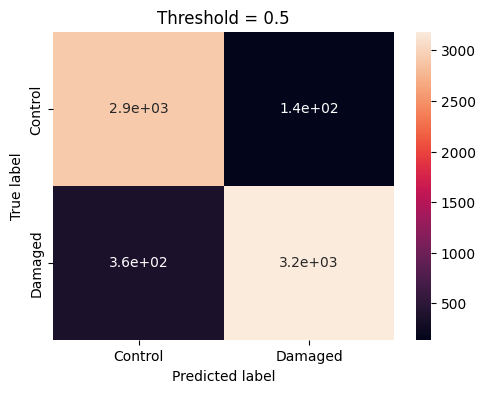

In [93]:
y_pred_train=grid_lr_acc.predict(X_train_dict['df_1_avg'])

print( f"Recall : {recall_score(Y_train_dict['df_1_avg'] ,y_pred_train ):.2f}"  )
print( f"accuracy : {accuracy_score(Y_train_dict['df_1_avg'] ,y_pred_train ):.2f}"  )
print( f"balanced accuracy : {balanced_accuracy_score(Y_train_dict['df_1_avg'] ,y_pred_train ):.2f}"  )
print( f"precision : {precision_score(Y_train_dict['df_1_avg'] ,y_pred_train ):.2f}"  )
print(f"F1 Score: {f1_score(Y_train_dict['df_1_avg'], y_pred_train):.2f}")

plotTitle = 'Threshold = 0.5'
plotConfusionMatrix(Y_train_dict['df_1_avg'], y_pred_train,
                    ['Control','Damaged'] , plotTitle ,
                    ax = None)


ROC curve

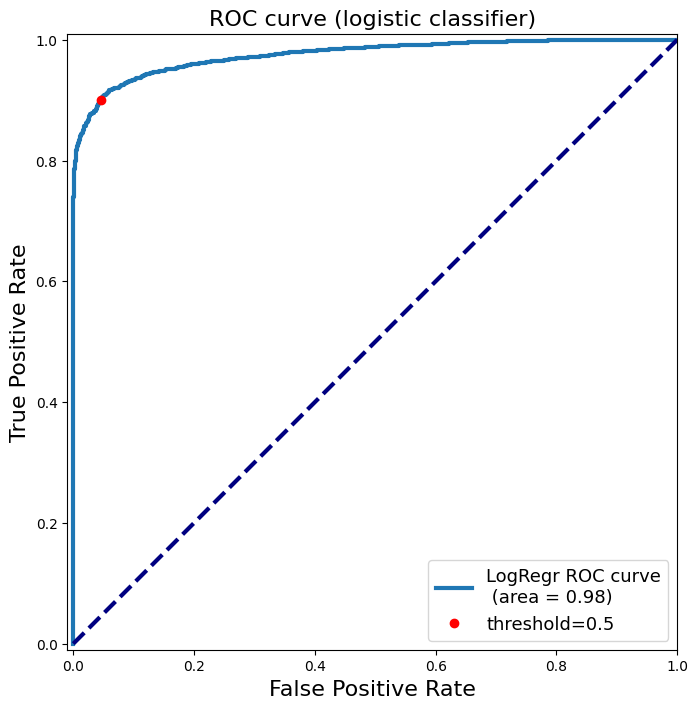

In [94]:
from sklearn.metrics import roc_curve, auc

y_score_train = grid_lr_acc.decision_function(X_train_dict['df_1_avg'])
fpr, tpr, thre = roc_curve(Y_train_dict['df_1_avg'], y_score_train)
roc_auc = auc(fpr, tpr)

threshold_level = 0.5
proba=sc.special.expit(thre)
threshold = sum( proba > threshold_level )-1

plt.figure(figsize=(8,8))
plt.axes().set_aspect('equal')
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr, tpr, lw=3, label='LogRegr ROC curve\n (area = {:0.2f})'.format(roc_auc))
plt.plot(fpr[threshold], tpr[threshold],'ro',label='threshold=0.5')
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve (logistic classifier)', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.show()

precision recall curve

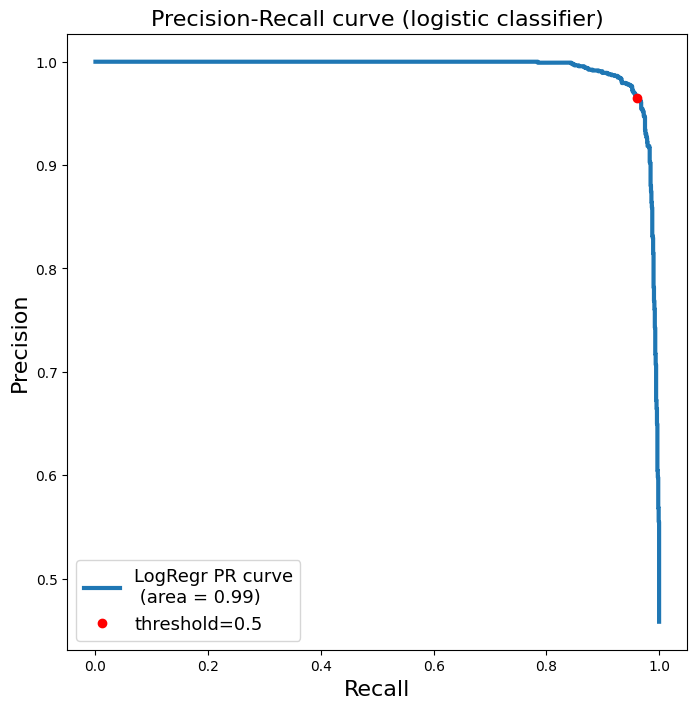

In [95]:
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

best_model = grid_lr_acc.best_estimator_

# Get the decision function scores for the test data
y_score_test = best_model.decision_function(X_test_dict['df_1_avg'])

# Calculate Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(Y_test_dict['df_1_avg'], y_score_test)

# Find the threshold closest to 0.5 probability level
proba = sc.special.expit(thresholds)
threshold_index = np.argmin(np.abs(proba - 0.5))

# Plot the Precision-Recall curve
plt.figure(figsize=(8, 8))
plt.plot(recall, precision, lw=3, label='LogRegr PR curve\n (area = {:0.2f})'.format(auc(recall, precision)))
plt.plot(recall[threshold_index], precision[threshold_index], 'ro', label='threshold=0.5')
plt.xlabel('Recall', fontsize=16)
plt.ylabel('Precision', fontsize=16)
plt.title('Precision-Recall curve (logistic classifier)', fontsize=16)
plt.legend(loc='lower left', fontsize=13)
plt.show()



#### Weights

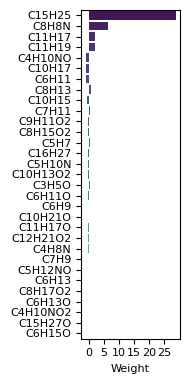

In [96]:
lr = grid_lr_acc.best_estimator_[1]
w = lr.coef_[0]  # get the weights

featureW = pd.DataFrame({'feature': X_train_dict['df_1_avg'].columns, 'weight': w})

featureWsorted = featureW.sort_values(by=['weight'], ascending=False, key=lambda col: col.abs())

# Filter non-null weights
featureWsorted = featureWsorted.loc[featureWsorted["weight"] != 0]

# Plotting
plt.figure(figsize=(2,3.94))
sns.barplot(x='weight', y='feature', data=featureWsorted, palette='viridis',hue="feature")
plt.xlabel('Weight', fontsize=8)
plt.ylabel('', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xticks(np.arange(0, featureWsorted['weight'].max() + 1, 5), fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()


#### Testing

Recall : 0.96
Accuracy : 0.97
Balanced Accuracy : 0.97
Precision : 0.97


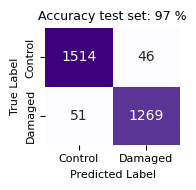

In [97]:
y_pred_test = (grid_lr_acc.predict_proba(X_test_dict['df_1_avg'])[:,1] >= 0.5).astype(bool)

# Calculate metrics
recall = recall_score(Y_test_dict['df_1_avg'], y_pred_test)
accuracy = accuracy_score(Y_test_dict['df_1_avg'], y_pred_test)
balanced_accuracy = balanced_accuracy_score(Y_test_dict['df_1_avg'], y_pred_test)
precision = precision_score(Y_test_dict['df_1_avg'], y_pred_test)
auc = roc_auc_score(Y_test_dict['df_1_avg'], y_pred_test)

print(f"Recall : {recall:.2f}")
print(f"Accuracy : {accuracy:.2f}")
print(f"Balanced Accuracy : {balanced_accuracy:.2f}")
print(f"Precision : {precision:.2f}")

# Create confusion matrix
cm = confusion_matrix(Y_test_dict['df_1_avg'], y_pred_test)
labels = ['Control', 'Damaged']

# Plotting
plt.figure(figsize=(2, 2))  # 10x10 cm in inches
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=labels, yticklabels=labels, cbar=False)
#plt.title(f'Confusion Matrix for Lasso Logistic Regression Model\n Accuracy: {accuracy:.2f}', fontsize=10)
plt.title(f'Accuracy test set: {accuracy*100:.0f} %', fontsize=9)
plt.xlabel('Predicted Label', fontsize=8)
plt.ylabel('True Label', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()

plt.show()


##4) By days

In [98]:
X_plants = result_avg_dfs['df_1_avg'].drop(['Plant','Treatment','measurement_ID','Distance'],axis=1)
y =  result_avg_dfs['df_1_avg']['Treatment']
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_encoded = pd.Series(y_encoded, index=y.index, name='Encoded_Column')

In [99]:
print(X_plants['Day'].unique())

['1' '2' '3']


In [100]:
def train_test_on_days(train_days, test_day):
    # Convert train_days and test_day to strings
    train_days = [str(day) for day in train_days]
    test_day = str(test_day)

    # Filter the data for the training and testing days
    X_train = X_plants[X_plants['Day'].isin(train_days)]
    y_train = y_encoded[X_plants['Day'].isin(train_days)]
    X_test = X_plants[X_plants['Day'] == test_day]
    y_test = y_encoded[X_plants['Day'] == test_day]

    # Print the size of the DataFrame X
    print(f"Size of DataFrame X: {X_train.shape}")

    # Separate X_train into features and groups
    plants_train = X_train['Sample_ID']
    X_train = X_train.drop('Sample_ID', axis=1)
    X_test = X_test.drop('Sample_ID', axis=1)

    # Define the logistic regression model with default C value
    logi_r = LogisticRegression(penalty='l1', max_iter=5000, solver='saga', n_jobs=-1,random_state=10)

    # Define the pipeline
    pipeline_log = Pipeline([('scalar', StandardScaler()), ('model', logi_r)])

    # Define the grouped k-fold
    groupedkfold = GroupKFold(n_splits=5)

    # Fit the model on the training data
    with warnings.catch_warnings():
        warnings.simplefilter('ignore', category=ConvergenceWarning)
        pipeline_log.fit(X_train, y_train)

    # Evaluate the model on the test data
    test_score = pipeline_log.score(X_test, y_test)
    y_pred_test = (pipeline_log.predict_proba(X_test)[:, 1] >= 0.5).astype(bool)

    # Return the test score and predictions
    return test_score, y_pred_test, y_test

# Define the days
days = [1, 2, 3]
results = []

# Loop over all combinations of training and testing days
for test_day in days:
    train_days = [day for day in days if day != test_day]
    test_score, y_pred_test, y_test = train_test_on_days(train_days, test_day)
    results.append({
        'Train Days': train_days,
        'Test Day': test_day,
        'Recall': recall_score(y_test, y_pred_test),
        'Accuracy': accuracy_score(y_test, y_pred_test),
        'Balanced Accuracy': balanced_accuracy_score(y_test, y_pred_test),
        'Precision': precision_score(y_test, y_pred_test)
    })

results_df = pd.DataFrame(results).round(2)
print(results_df)


Size of DataFrame X: (6360, 33)
Size of DataFrame X: (6480, 33)
Size of DataFrame X: (6120, 33)
  Train Days  Test Day  Recall  Accuracy  Balanced Accuracy  Precision
0     [2, 3]         1    0.84      0.90               0.90       0.96
1     [1, 3]         2    0.90      0.92               0.92       0.96
2     [1, 2]         3    0.89      0.94               0.94       0.99


#B) **4-5 cm Distance**

##1) Test classifiers on all intervals from each 60-second measurements

###Cut into intervals

In [101]:
Data = D45cm.copy()
# Define the time intervals
time_intervals = [1, 5, 15, 30, 60]

# Initialize an empty dictionary to store the resulting DataFrames
result_dfs = {}

# Loop over each time interval
for interval in time_intervals:
    # Group by Sample_ID and cut the data into parts of the current time interval
    df = Data.groupby('Sample_ID').apply(lambda x: x.assign(measurement_ID=x.name + '_' + (x.index//interval).astype(str)).iloc[:x.shape[0]//interval*interval])

    # Reset the index
    df = df.reset_index(drop=True)

    # Store the resulting DataFrame in the dictionary with a unique name
    result_dfs[f'df_{interval}'] = df

### Average

In [102]:
# Define the columns to keep
keep_columns = ['Sample_ID', 'Plant', 'Distance', 'Day', 'Treatment']

# Initialize an empty dictionary to store the resulting DataFrames
result_avg_dfs = {}

# Loop over each DataFrame in the dictionary
for name, df in result_dfs.items():
    # Get the columns
    average_columns = df.loc[:, 'C3H5O':'C15H27O'].columns.tolist()

    # Calculate the average for the specified columns for each measurement_ID
    df_avg = df.groupby(['measurement_ID'] + keep_columns)[average_columns].mean().reset_index()

    # Store the resulting DataFrame in the dictionary with a unique name
    result_avg_dfs[f'{name}_avg'] = df_avg

#Print the resulting DataFrames
for name, df in result_avg_dfs.items():
     print(f"\n{name} DataFrame:\n")
     print(df.shape)


df_1_avg DataFrame:

(9480, 37)

df_5_avg DataFrame:

(1896, 37)

df_15_avg DataFrame:

(632, 37)

df_30_avg DataFrame:

(316, 37)

df_60_avg DataFrame:

(158, 37)


### Train-Test separation

The group_split function performs a grouped split of the dataset into training and testing sets, ensuring that data from the same plant are not split between the training and testing sets. This helps to avoid data leakage and ensures a more robust evaluation of the model

In [103]:
# Initialize dictionaries to store results
plants_train_dict = {}
plants_test_dict = {}
X_train_dict = {}
X_test_dict = {}
Y_train_dict = {}
Y_test_dict = {}

# Function to perform grouped split
def group_split(X, y, group, train_size=0.7):
    splitter = GroupShuffleSplit(train_size=train_size, random_state=10)
    train, test = next(splitter.split(X, y, groups=group))
    return (X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test])

# Iterate over each key in the dictionary
for key, df in result_avg_dfs.items():
    # Define X and y
    X_plants = df.drop(['Treatment', 'Day','Plant','measurement_ID','Distance'], axis=1)
    y = df['Treatment']

    # Encode the labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    y_encoded = pd.Series(y_encoded, index=y.index, name='Encoded_Column')

    # Perform the grouped split
    X_train, X_test, y_train, y_test = group_split(X_plants, y_encoded, X_plants['Sample_ID'])

    # Separate X_train into features and groups
    plants_train = X_train['Sample_ID']
    plants_test = X_test['Sample_ID']
    X_train = X_train.drop('Sample_ID', axis=1)
    X_test = X_test.drop('Sample_ID', axis=1)

    # Store the results in the dictionaries
    plants_train_dict[key] = plants_train
    plants_test_dict[key] = plants_test
    X_train_dict[key] = X_train
    Y_train_dict[key] = y_train
    X_test_dict[key] = X_test
    Y_test_dict[key] = y_test

for name, df in X_train_dict.items():
     print(f"\n{name} DataFrame:\n")
     print(df.shape)


df_1_avg DataFrame:

(6600, 31)

df_5_avg DataFrame:

(1320, 31)

df_15_avg DataFrame:

(440, 31)

df_30_avg DataFrame:

(220, 31)

df_60_avg DataFrame:

(110, 31)


### Classifiers
Using grouped cross-validation ensures that measurements from the same plant are not found in both the training and testing folds.


In [104]:
kfold = GroupKFold(n_splits=5)
scaler = StandardScaler()

# Function to train and evaluate the model
def evaluate_model(X_train, y_train, group, model):
    X_train_scaled = scaler.fit_transform(X_train)
    accuracy = cross_val_score(model, X_train_scaled, y_train, cv=kfold, groups=group)
    return accuracy.mean(), accuracy.std()

models = {
    "Logistic Regression": LogisticRegression(penalty='l1', random_state=10, solver='saga', max_iter=5000),
    "KNeighbors": KNeighborsClassifier(),
    "SVM": SVC(probability=True, random_state=10),
    "Decision Tree": DecisionTreeClassifier(random_state=10),
    "Random Forest": RandomForestClassifier(random_state=10)
}

# Initialize a list to store the results
results_list = []

# Loop over each key in the dictionaries
for key in X_train_dict.keys():
    for name, model in models.items():
        mean_acc, std_acc = evaluate_model(X_train_dict[key], Y_train_dict[key], plants_train_dict[key], model)
        results_list.append({
            'Dataset': key,
            'Model': name,
            'Accuracy Mean': mean_acc,
            'Accuracy Std': std_acc
        })

# Convert the results list to a DataFrame
results_df = pd.DataFrame(results_list).round(2)

# Print the results DataFrame
print(results_df)

      Dataset                Model  Accuracy Mean  Accuracy Std
0    df_1_avg  Logistic Regression           0.89          0.04
1    df_1_avg           KNeighbors           0.72          0.04
2    df_1_avg                  SVM           0.86          0.01
3    df_1_avg        Decision Tree           0.83          0.02
4    df_1_avg        Random Forest           0.88          0.03
5    df_5_avg  Logistic Regression           0.90          0.05
6    df_5_avg           KNeighbors           0.72          0.07
7    df_5_avg                  SVM           0.84          0.03
8    df_5_avg        Decision Tree           0.87          0.03
9    df_5_avg        Random Forest           0.89          0.04
10  df_15_avg  Logistic Regression           0.92          0.05
11  df_15_avg           KNeighbors           0.75          0.09
12  df_15_avg                  SVM           0.84          0.05
13  df_15_avg        Decision Tree           0.90          0.03
14  df_15_avg        Random Forest      

## 2) Testing classifiers on the first instance of each interval only


### Cut into intervals

In [105]:
# Define the time intervals
time_intervals = [1, 5, 15, 30, 60]

# Initialize an empty dictionary to store the resulting DataFrames
result_dfs2 = {}

# Loop over each time interval
for interval in time_intervals:
    # Group by Sample_ID and cut the data into parts of the current time interval
    df = Data.groupby('Sample_ID').apply(lambda x: x.iloc[:interval].assign(measurement_ID=x.name + '_0'))

    # Reset the index
    df = df.reset_index(drop=True)

    # Store the resulting DataFrame in the dictionary with a unique name
    result_dfs2[f'df_{interval}'] = df

### Average

In [106]:
# Define the columns to keep
keep_columns = ['Sample_ID', 'Plant', 'Distance', 'Day', 'Treatment']

# Initialize an empty dictionary to store the resulting DataFrames
result_avg_dfs2 = {}

# Loop over each DataFrame in the dictionary
for name, df in result_dfs2.items():
    # Get the columns
    average_columns = df.loc[:, 'C3H5O':'C15H27O'].columns.tolist()

    # Calculate the average for the specified columns for each measurement_ID
    df_avg = df.groupby(['measurement_ID'] + keep_columns)[average_columns].mean().reset_index()

    # Store the resulting DataFrame in the dictionary with a unique name
    result_avg_dfs2[f'{name}_avg'] = df_avg

#Print the resulting DataFrames
for name, df in result_avg_dfs2.items():
     print(f"\n{name} DataFrame:\n")
     print(df.shape)



df_1_avg DataFrame:

(158, 37)

df_5_avg DataFrame:

(158, 37)

df_15_avg DataFrame:

(158, 37)

df_30_avg DataFrame:

(158, 37)

df_60_avg DataFrame:

(158, 37)


### Train-Test separation

In [107]:
# Initialize dictionaries to store results
plants_train_dict2 = {}
X_train_dict2 = {}
X_test_dict2 = {}
Y_train_dict2 = {}
Y_test_dict2 = {}

# Iterate over each key in the dictionary
for key, df in result_avg_dfs2.items():
    # Define X and y
    X_plants = df.drop(['Treatment', 'Day','Plant','measurement_ID','Distance'], axis=1)
    y = df['Treatment']

    # Encode the labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    y_encoded = pd.Series(y_encoded, index=y.index, name='Encoded_Column')

    # Perform the split
    X_train, X_test, y_train, y_test = train_test_split(X_plants, y_encoded, test_size=0.3, shuffle=True,random_state=10)

    # Separate X_train into features and groups
    plants_train = X_train['Sample_ID']
    X_train = X_train.drop('Sample_ID', axis=1)
    X_test = X_test.drop('Sample_ID', axis=1)

    # Store the results in the dictionaries
    plants_train_dict2[key] = plants_train
    X_train_dict2[key] = X_train
    Y_train_dict2[key] = y_train
    X_test_dict2[key] = X_test
    Y_test_dict2[key] = y_test


for name, df in X_train_dict2.items():
     print(f"\n{name} DataFrame:\n")
     print(df.shape)



df_1_avg DataFrame:

(110, 31)

df_5_avg DataFrame:

(110, 31)

df_15_avg DataFrame:

(110, 31)

df_30_avg DataFrame:

(110, 31)

df_60_avg DataFrame:

(110, 31)


### Classifiers

In [108]:
kfold = KFold(n_splits=5,random_state=10,shuffle=True)
scaler = StandardScaler()

# Function to train and evaluate the model
def evaluate_model(X_train, y_train, model):
    X_train_scaled = scaler.fit_transform(X_train)
    accuracy = cross_val_score(model, X_train_scaled, y_train, cv=kfold)
    return accuracy.mean(), accuracy.std()

models = {
    "Logistic Regression": LogisticRegression(penalty='l1', random_state=10, solver='saga', max_iter=5000),
    "KNeighbors": KNeighborsClassifier(),
    "SVM": SVC(probability=True, random_state=10),
    "Decision Tree": DecisionTreeClassifier(random_state=10),
    "Random Forest": RandomForestClassifier(random_state=10),
}

# Initialize a list to store the results
results_list = []

# Loop over each key in the dictionaries
for key in X_train_dict2.keys():
    for name, model in models.items():
        mean_acc, std_acc = evaluate_model(X_train_dict2[key],Y_train_dict2[key], model)
        results_list.append({
            'Dataset': key,
            'Model': name,
            'Accuracy Mean': mean_acc,
            'Accuracy Std': std_acc
        })

# Convert the results list to a DataFrame
results_df = pd.DataFrame(results_list).round(2)

# Print the results DataFrame
print(results_df)

      Dataset                Model  Accuracy Mean  Accuracy Std
0    df_1_avg  Logistic Regression           0.84          0.05
1    df_1_avg           KNeighbors           0.67          0.09
2    df_1_avg                  SVM           0.67          0.06
3    df_1_avg        Decision Tree           0.81          0.05
4    df_1_avg        Random Forest           0.85          0.05
5    df_5_avg  Logistic Regression           0.89          0.04
6    df_5_avg           KNeighbors           0.65          0.15
7    df_5_avg                  SVM           0.71          0.08
8    df_5_avg        Decision Tree           0.82          0.06
9    df_5_avg        Random Forest           0.88          0.04
10  df_15_avg  Logistic Regression           0.92          0.03
11  df_15_avg           KNeighbors           0.73          0.08
12  df_15_avg                  SVM           0.75          0.08
13  df_15_avg        Decision Tree           0.85          0.03
14  df_15_avg        Random Forest      

## 3) Working on 1-second intervals

### Thuning regularization

Using grouped cross-validation.
Best hyperparameter C = 0.112




In [109]:
logi_r=LogisticRegression(penalty='l1', max_iter=5000,
                          solver='saga',n_jobs=-1,class_weight=None,random_state=10)

groupedkfold = GroupKFold(n_splits=5)

pipeline_log=Pipeline([('scalar',StandardScaler()),
                      ('model',logi_r)])

# Define the parameter grid
param_grid = {
    'model__C': np.linspace(0.001, 1, 10)
}

grid_lr_acc = GridSearchCV(pipeline_log,
                           param_grid,
                           scoring='accuracy',
                           cv=groupedkfold,
                           n_jobs=-1)

with warnings.catch_warnings():
    warnings.simplefilter('ignore',  category=ConvergenceWarning)
    grid_lr_acc.fit(X_train_dict['df_1_avg'], Y_train_dict['df_1_avg'],groups=plants_train_dict['df_1_avg'])

print('Grid best parameter: ', grid_lr_acc.best_params_)#get the best parameters

Grid best parameter:  {'model__C': 0.112}


### Performance on train set

In [110]:
def plotConfusionMatrix( true_labels, predicted_labels, label_list , title , ax = None):

    confusion_mc_c = confusion_matrix(true_labels, predicted_labels)
    df_cm_c = pd.DataFrame( confusion_mc_c ,
                           index = label_list,
                           columns=label_list)

    if ax is None:
        fig,ax = plt.subplots(figsize=(5.5,4))
    sns.heatmap(df_cm_c, annot=True , ax = ax)
    ax.set_title(title)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

Recall : 0.90
accuracy : 0.92
balanced accuracy : 0.93
precision : 0.95
F1 Score: 0.93


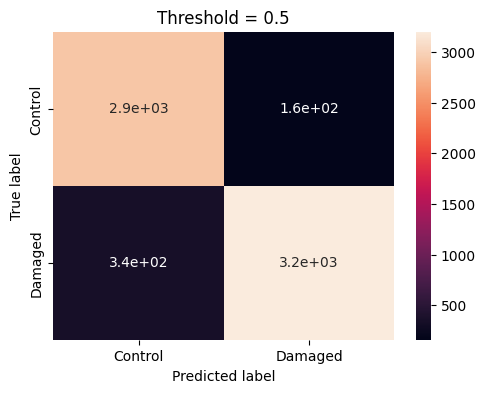

In [111]:
y_pred_train=grid_lr_acc.predict(X_train_dict['df_1_avg'])

print( f"Recall : {recall_score(Y_train_dict['df_1_avg'] ,y_pred_train ):.2f}"  )
print( f"accuracy : {accuracy_score(Y_train_dict['df_1_avg'] ,y_pred_train ):.2f}"  )
print( f"balanced accuracy : {balanced_accuracy_score(Y_train_dict['df_1_avg'] ,y_pred_train ):.2f}"  )
print( f"precision : {precision_score(Y_train_dict['df_1_avg'] ,y_pred_train ):.2f}"  )
print(f"F1 Score: {f1_score(Y_train_dict['df_1_avg'], y_pred_train):.2f}")

plotTitle = 'Threshold = 0.5'
plotConfusionMatrix(Y_train_dict['df_1_avg'], y_pred_train,
                    ['Control','Damaged'] , plotTitle ,
                    ax = None)


ROC curve

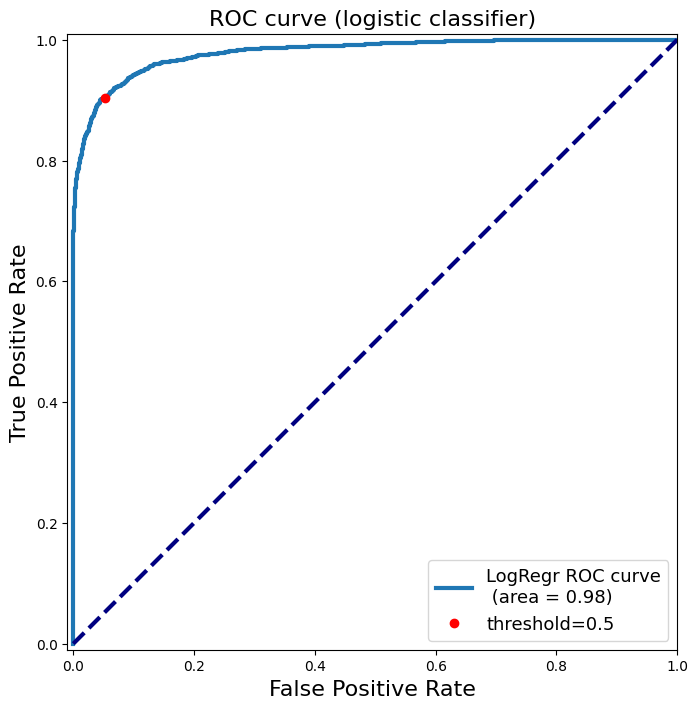

In [112]:
from sklearn.metrics import roc_curve, auc

y_score_train = grid_lr_acc.decision_function(X_train_dict['df_1_avg'])
fpr, tpr, thre = roc_curve(Y_train_dict['df_1_avg'], y_score_train)
roc_auc = auc(fpr, tpr)

threshold_level = 0.5
proba=sc.special.expit(thre)
threshold = sum( proba > threshold_level )-1

plt.figure(figsize=(8,8))
plt.axes().set_aspect('equal')
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr, tpr, lw=3, label='LogRegr ROC curve\n (area = {:0.2f})'.format(roc_auc))
plt.plot(fpr[threshold], tpr[threshold],'ro',label='threshold=0.5')
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve (logistic classifier)', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.show()

Precision-recall curve

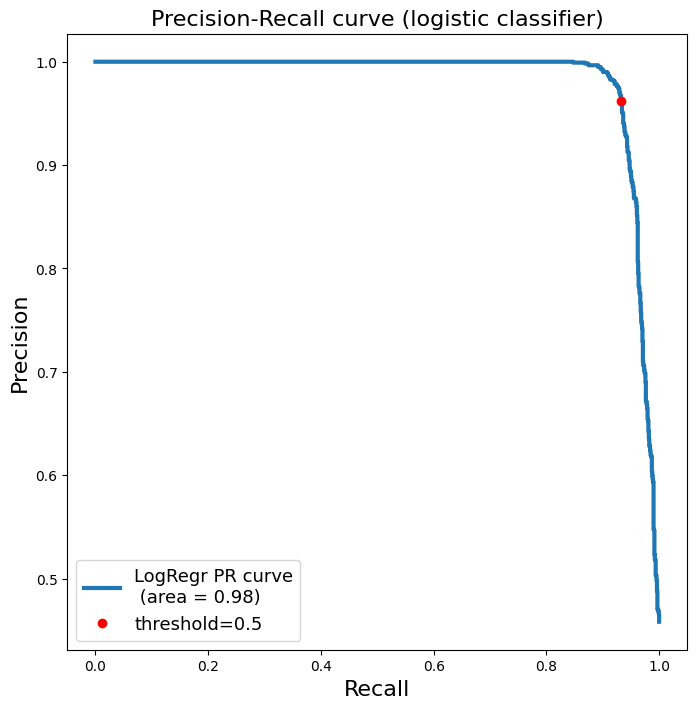

In [113]:
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

best_model = grid_lr_acc.best_estimator_

# Get the decision function scores for the test data
y_score_test = best_model.decision_function(X_test_dict['df_1_avg'])

# Calculate Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(Y_test_dict['df_1_avg'], y_score_test)

# Find the threshold closest to 0.5 probability level
proba = sc.special.expit(thresholds)
threshold_index = np.argmin(np.abs(proba - 0.4))

# Plot the Precision-Recall curve
plt.figure(figsize=(8, 8))
plt.plot(recall, precision, lw=3, label='LogRegr PR curve\n (area = {:0.2f})'.format(auc(recall, precision)))
plt.plot(recall[threshold_index], precision[threshold_index], 'ro', label='threshold=0.5')
plt.xlabel('Recall', fontsize=16)
plt.ylabel('Precision', fontsize=16)
plt.title('Precision-Recall curve (logistic classifier)', fontsize=16)
plt.legend(loc='lower left', fontsize=13)
plt.show()



#### Weights

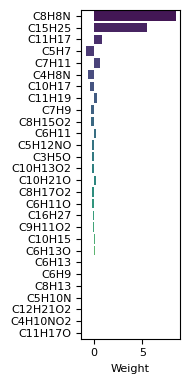

In [114]:
lr = grid_lr_acc.best_estimator_[1]
w = lr.coef_[0]  # get the weights

featureW = pd.DataFrame({'feature': X_train_dict['df_1_avg'].columns, 'weight': w})

featureWsorted = featureW.sort_values(by=['weight'], ascending=False, key=lambda col: col.abs())

# Filter non-null weights
featureWsorted = featureWsorted.loc[featureWsorted["weight"] != 0]

# Plotting
plt.figure(figsize=(2,3.94))  # 10x10 cm in inches
sns.barplot(x='weight', y='feature', data=featureWsorted, palette='viridis',hue='feature')
#plt.title('Feature Importance', fontsize=8)
plt.xlabel('Weight', fontsize=8)
plt.ylabel('', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()

plt.show()


#### Testing

Recall : 0.92
Accuracy : 0.96
Balanced Accuracy : 0.95
Precision : 0.98


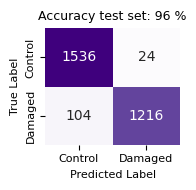

In [115]:
y_pred_test = (grid_lr_acc.predict_proba(X_test_dict['df_1_avg'])[:,1] >= 0.5).astype(bool)

# Calculate metrics
recall = recall_score(Y_test_dict['df_1_avg'], y_pred_test)
accuracy = accuracy_score(Y_test_dict['df_1_avg'], y_pred_test)
balanced_accuracy = balanced_accuracy_score(Y_test_dict['df_1_avg'], y_pred_test)
precision = precision_score(Y_test_dict['df_1_avg'], y_pred_test)
auc = roc_auc_score(Y_test_dict['df_1_avg'], y_pred_test)

print(f"Recall : {recall:.2f}")
print(f"Accuracy : {accuracy:.2f}")
print(f"Balanced Accuracy : {balanced_accuracy:.2f}")
print(f"Precision : {precision:.2f}")

# Create confusion matrix
cm = confusion_matrix(Y_test_dict['df_1_avg'], y_pred_test)
labels = ['Control', 'Damaged']

# Plotting
plt.figure(figsize=(2, 2))  # 10x10 cm in inches
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=labels, yticklabels=labels, cbar=False)
#plt.title(f'Confusion Matrix for Lasso Logistic Regression Model\n Accuracy: {accuracy:.2f}', fontsize=10)
plt.title(f'Accuracy test set: {accuracy*100:.0f} %', fontsize=9)
plt.xlabel('Predicted Label', fontsize=8)
plt.ylabel('True Label', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()



### 4) By days

In [116]:
X_plants = result_avg_dfs['df_1_avg'].drop(['Plant','Treatment','measurement_ID','Distance'],axis=1)
y =  result_avg_dfs['df_1_avg']['Treatment']
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_encoded = pd.Series(y_encoded, index=y.index, name='Encoded_Column')

In [117]:
print(X_plants['Day'].unique())

['1' '2' '3']


In [118]:
def train_test_on_days(train_days, test_day):
    # Convert train_days and test_day to strings
    train_days = [str(day) for day in train_days]
    test_day = str(test_day)

    # Filter the data for the training and testing days
    X_train = X_plants[X_plants['Day'].isin(train_days)]
    y_train = y_encoded[X_plants['Day'].isin(train_days)]
    X_test = X_plants[X_plants['Day'] == test_day]
    y_test = y_encoded[X_plants['Day'] == test_day]

    # Print the size of the DataFrame X
    print(f"Size of DataFrame X: {X_train.shape}")

    # Separate X_train into features and groups
    plants_train = X_train['Sample_ID']
    X_train = X_train.drop('Sample_ID', axis=1)
    X_test = X_test.drop('Sample_ID', axis=1)

    # Define the logistic regression model with default C value
    logi_r = LogisticRegression(penalty='l1', max_iter=5000, solver='saga', n_jobs=-1,random_state=10)

    # Define the pipeline
    pipeline_log = Pipeline([('scalar', StandardScaler()), ('model', logi_r)])

    # Define the grouped k-fold
    groupedkfold = GroupKFold(n_splits=5)

    # Fit the model on the training data
    with warnings.catch_warnings():
        warnings.simplefilter('ignore', category=ConvergenceWarning)
        pipeline_log.fit(X_train, y_train)

    # Evaluate the model on the test data
    test_score = pipeline_log.score(X_test, y_test)
    y_pred_test = (pipeline_log.predict_proba(X_test)[:, 1] >= 0.5).astype(bool)

    # Return the test score and predictions
    return test_score, y_pred_test, y_test

# Define the days
days = [1, 2, 3]
results = []

# Loop over all combinations of training and testing days
for test_day in days:
    train_days = [day for day in days if day != test_day]
    test_score, y_pred_test, y_test = train_test_on_days(train_days, test_day)
    results.append({
        'Train Days': train_days,
        'Test Day': test_day,
        'Recall': recall_score(y_test, y_pred_test),
        'Accuracy': accuracy_score(y_test, y_pred_test),
        'Balanced Accuracy': balanced_accuracy_score(y_test, y_pred_test),
        'Precision': precision_score(y_test, y_pred_test)
    })

results_df = pd.DataFrame(results).round(2)
print(results_df)


Size of DataFrame X: (6360, 33)
Size of DataFrame X: (6480, 33)
Size of DataFrame X: (6120, 33)
  Train Days  Test Day  Recall  Accuracy  Balanced Accuracy  Precision
0     [2, 3]         1    0.81      0.87               0.87       0.93
1     [1, 3]         2    0.91      0.92               0.92       0.94
2     [1, 2]         3    0.89      0.94               0.94       0.99
